In [118]:
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn import metrics
import warnings
import json
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")
warnings.filterwarnings("ignore", "is_sparse")


In [119]:
model_name, version = 'CTCF_inv', 0
# model_name, version, run_descr = 'only_one_exp', 0, 'BATF2 GHTS/GHTS'
path_to_model = '/home/nikgr/mex_models/%s' % model_name
path_to_metrics = path_to_model + '/model/lightning_logs/version_%d/metrics.csv' % version
path_to_preds = path_to_model + '/model/predictions_new_format.tsv'
path_to_conf = path_to_model + '/config.json'
model_full_descr = 'LegNet (%s)' % (model_name)

In [120]:
print(path_to_conf)
with open(path_to_conf) as f:
    model_config = json.load(f)
print(model_config)

/home/nikgr/mex_models/CTCF_inv/config.json
{'stem_ch': 64, 'stem_ks': 40, 'ef_ks': 9, 'ef_block_sizes': [80, 96, 112, 128], 'resize_factor': 4, 'pool_sizes': [2, 2, 2, 2], 'reverse_augment': True, 'use_reverse_channel': True, 'use_shift': True, 'max_shift': [25, 25], 'max_lr': 0.01, 'weight_decay': 0.1, 'model_dir': '/home/nikgr/mex_models/CTCF_inv', 'train_path': '/home/nikgr/MEX/DATASETS/GHTS/Train/CTCF', 'ref_genome_path': '/home/nikgr/hg38/hg38.fa', 'valid_path': '/home/nikgr/MEX/DATASETS/GHTS/Test/CTCF', 'test_path': '/home/nikgr/MEX/DATASETS/CHS/Test/CTCF', 'epoch_num': 15, 'device': 1, 'seed': 777, 'train_batch_size': 1024, 'valid_batch_size': 1024, 'num_workers': 8, 'training': True}


In [121]:
def get_aug_info(conf):
    aug = []
    if conf['reverse_augment']:
        aug.append('rev')
    if conf['use_shift']:
        # aug.append(f'{conf["max_shift"][0]}-{conf["max_shift"][1]} shift')
        aug.append(f'{conf["max_shift"][0]} shift')
    if len(aug) == 0:
        aug.append('w/o aug')
    else:
        aug[0] = 'with ' + aug[0]
        aug[-1] = aug[-1] + ' aug'
    return 'LegNet ' + ' & '.join(aug) + f', {conf["epoch_num"]} ep.'

def get_run_info(conf):
    train_split = conf["train_path"].split("/")
    return f'{train_split[-1]} {train_split[-3]}/{conf["test_path"].split("/")[-3]}'

aug_info = get_aug_info(model_config)
run_info = get_run_info(model_config)
print(aug_info)
print(run_info)

LegNet with rev & 25 shift aug, 15 ep.
CTCF GHTS/CHS


In [122]:
metrics_df = pd.read_csv(path_to_metrics, sep=',')
metrics_df.head()
left_df = metrics_df[['val_loss', 'val_auroc', 'epoch', 'step']].dropna()
right_df = metrics_df[['epoch', 'step', 'train_loss']].dropna()
metrics_df = pd.merge(left_df, right_df, on=['epoch', 'step'])
metrics_df.head()
metrics_df.tail()

,val_loss,val_auroc,epoch,step,train_loss
10,0.016588,0.993696,10,6335,0.016948
11,0.014822,0.994632,11,6911,0.015451
12,0.012254,0.995325,12,7487,0.013919
13,0.011506,0.995494,13,8063,0.012265
14,0.011230,0.995764,14,8639,0.011378


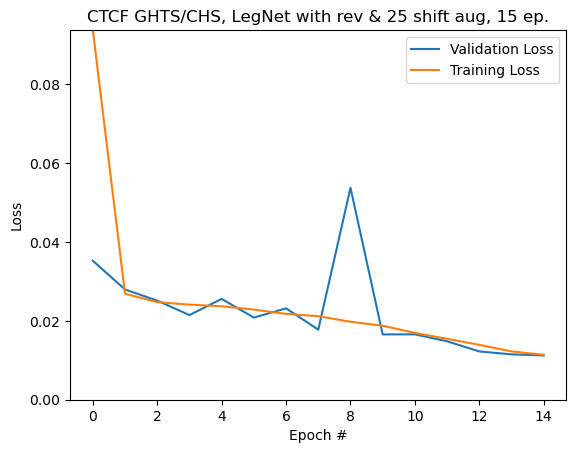

In [123]:
ax = plt.axes()
ax.set_ylim(0, max(metrics_df['val_loss'].max(), metrics_df['train_loss'].max()))
plt.plot(metrics_df['epoch'], metrics_df['val_loss'], label='Validation Loss')
plt.plot(metrics_df['epoch'], metrics_df['train_loss'], label='Training Loss')
plt.title('%s, %s' % (run_info, aug_info))
plt.ylabel('Loss')
plt.xlabel('Epoch #')
plt.legend(loc='upper right')
plt.show()


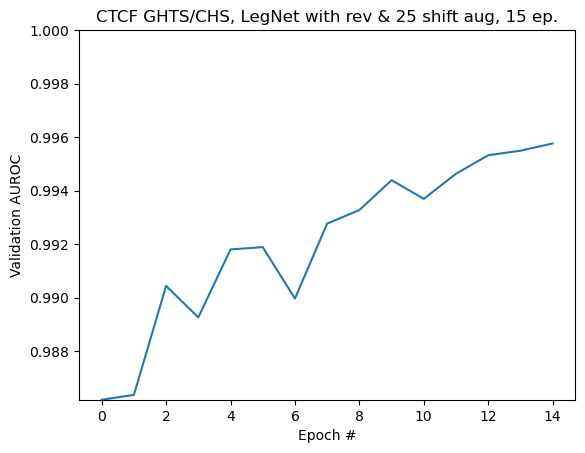

In [124]:
ax = plt.axes()
ax.set_ylim(metrics_df['val_auroc'].min(), 1)
plt.plot(metrics_df['epoch'], metrics_df['val_auroc'])
plt.title('%s, %s' % (run_info, aug_info))
plt.ylabel('Validation AUROC')
plt.xlabel('Epoch #')
plt.show()

In [125]:
preds_df = pd.read_csv(path_to_preds, sep='\t')
preds_df['avg_pred'] = (preds_df['forw_pred'] + preds_df['rev_pred']) / 2
preds = ('forw_pred', 'avg_pred')
preds_names = {'forw_pred': 'forward', 'rev_pred': 'reverse', 'avg_pred': 'averaged'}

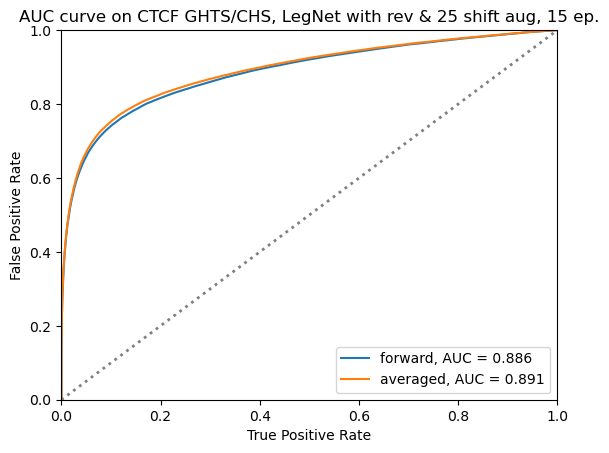

In [126]:
ax = plt.axes()
ax.axline([0, 0], [1, 1], linewidth=2, color='grey', linestyle=':')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
plt.title(f'AUC curve on {run_info}, {aug_info}')
    
for pred in preds:
    fpr, tpr, _ = metrics.roc_curve(preds_df['class_'], preds_df[pred])
    auc = metrics.roc_auc_score(preds_df['class_'], preds_df[pred])

    plt.plot(fpr, tpr, label=f'{preds_names[pred]}, AUC = {auc:.3}')
    plt.ylabel('False Positive Rate')
    plt.xlabel('True Positive Rate')
    plt.legend(loc='lower right')
plt.show()

In [127]:
preds_df.head()

,chr,start,end,class_,forw_pred,rev_pred,avg_pred
0,chr10,50689,50990,0,0.000070,0.000073,0.000071
1,chr10,51149,51450,0,0.000181,0.000113,0.000147
2,chr10,57820,58121,0,0.000062,0.000057,0.000059
3,chr10,57881,58182,0,0.000113,0.000112,0.000113
4,chr10,57948,58249,0,0.000105,0.000117,0.000111


In [128]:
preds_df.tail()

,chr,start,end,class_,forw_pred,rev_pred,avg_pred
1217904,chr8,145020015,145020316,1,0.992700,0.996600,0.994650
1217905,chr8,145026762,145027063,1,0.954000,0.879000,0.916500
1217906,chr8,145052596,145052897,1,0.014175,0.014175,0.014175
1217907,chr8,145065972,145066273,1,0.433300,0.505400,0.469350
1217908,chr8,145069498,145069799,1,0.024100,0.024700,0.024400
